In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import seaborn as sns

In [2]:
#import data(source:https://www.kaggle.com/datasets/mylesoneill/world-university-rankings/dat)
data=pd.read_csv("cwurData.csv")
df=pd.DataFrame(data)

data preprocessing

1.check null value:

In [3]:
df.isnull().any(axis=0)

world_rank              False
institution             False
country                 False
national_rank           False
quality_of_education    False
alumni_employment       False
quality_of_faculty      False
publications            False
influence               False
citations               False
broad_impact             True
patents                 False
score                   False
year                    False
dtype: bool

In [4]:
df.loc[df.isnull().any(axis=1)]

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,96,Australian National University,Australia,2,101,101,43,101,101,101,NaN,101,44.50,2013
196,97,University of Alberta,Canada,4,101,101,101,68,101,92,NaN,81,44.50,2013
197,98,University of Helsinki,Finland,1,69,101,81,74,79,71,NaN,101,44.39,2013
198,99,Paris Diderot University - Paris 7,France,5,28,101,72,101,87,101,NaN,101,44.36,2013


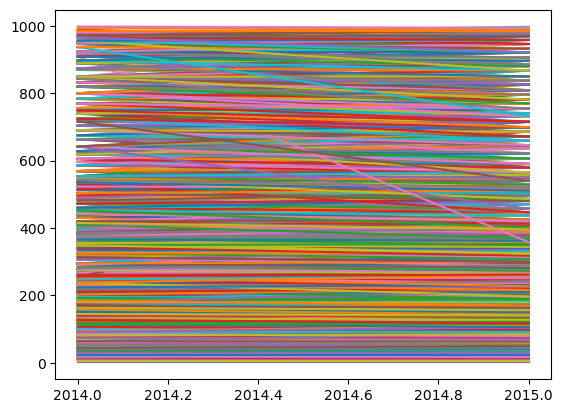

In [5]:
#we found that the data for broad_impact values are missing for 2012 and 2013,so we make the following graph to show 
#how every institutions' broad impact change in 2014 and 2015
x=df.year[df["year"]>2013].unique()
for i in df.institution.unique():
    y=df.broad_impact[(df.institution==i)&(df.year>2013)]
    if(len(x)==len(y)):
        plt.plot(x,y)   

In [6]:
#as we can found in the graph, the broad impact of most institutions does not change dramatically
#so we can use the average value of an institution's exsiting values of 2014 and 2015 to fill up null values
average_impact = df[df['year'].isin([2014, 2015])].groupby('institution')['broad_impact'].mean()#calculate the average values for every institution
df_filled = df.merge(average_impact, how='left', on='institution', suffixes=('', '_avg'))#merge the values into dataframe as a new column
df_filled['broad_impact'].fillna(df_filled['broad_impact_avg'], inplace=True)#fill up the NaN values with the values in new column
df_filled.drop('broad_impact_avg', axis=1, inplace=True)#drop the new column as it is not useful anymore
df_filled.isnull().any(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
2195    False
2196    False
2197    False
2198    False
2199    False
Length: 2200, dtype: bool

2.check duplicated values

In [7]:
df.duplicated().any

<bound method Series.any of 0       False
1       False
2       False
3       False
4       False
        ...  
2195    False
2196    False
2197    False
2198    False
2199    False
Length: 2200, dtype: bool>

3.because the data use the same unit and do not have the extrame values so we omit the data standardization and normalization

EDA

1. what are the top 10 universities?

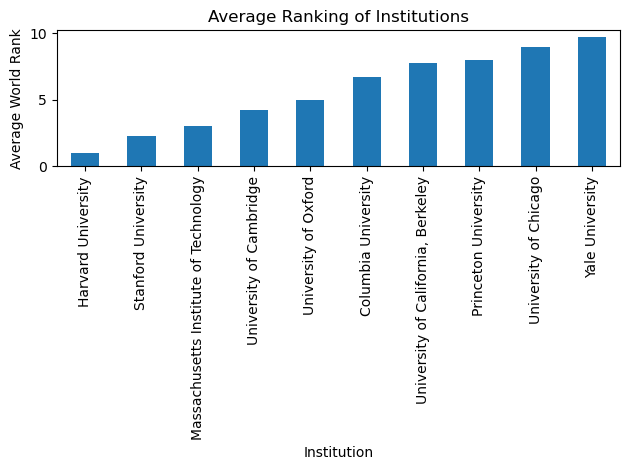

In [8]:
#calculate the average ranks to see the top 10 universities
average_rank_per_institution = df.groupby('institution')['world_rank'].mean()
average_rank_per_institution.sort_values().head(10).plot(kind='bar')#filter the top 10 universities that have the least ranks
plt.title('Average Ranking of Institutions')
plt.xlabel('Institution')
plt.ylabel('Average World Rank')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

We can see from the graph that the top 10 universities are: Harvard, Stanford, MIT, University of Cambridge，University of Oxford, University of California berkeley, Princeton University University of Chicago, Yale.

2.Which countries are better in education?

<Axes: ylabel='the countries that top 10 universities belongs to'>

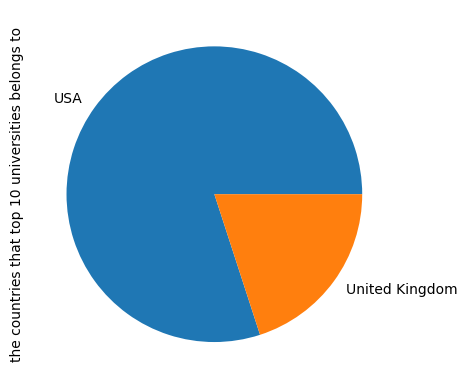

In [9]:
top_institutions_under_100 = average_rank_per_institution[average_rank_per_institution < 10]
# Count the occurrences of each country
country_counts = df[df['institution'].isin(top_institutions_under_100.index)]['country'].value_counts()
country_counts.plot(kind="pie",label="the countries that top 10 universities belongs to")

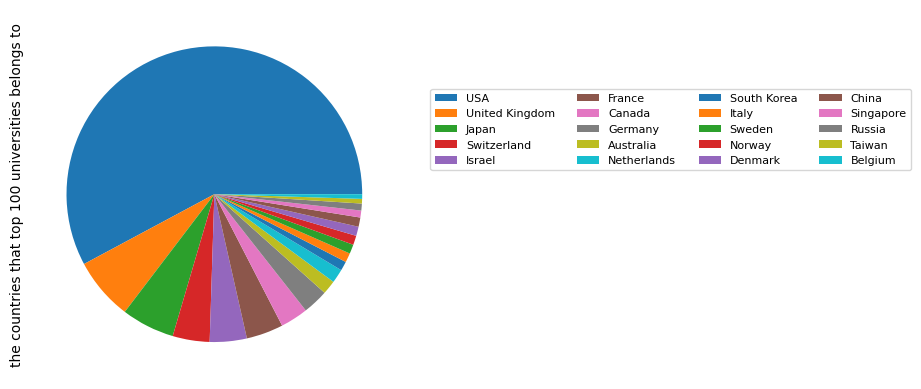

In [10]:
top_institutions_under_100 = average_rank_per_institution[average_rank_per_institution < 100]
# Count the occurrences of each country
country_counts = df[df['institution'].isin(top_institutions_under_100.index)]['country'].value_counts()
kinds=country_counts.index
country_counts.plot(kind="pie",label="the countries that top 100 universities belongs to",labels=None) 
plt.legend(kinds, loc='upper right', 
 bbox_to_anchor=[2.4, 0.8],
prop={'size':8},ncol=4)

It is obvious that USA is taking the lead as the most of Universities in top 10 and top 100 belong to it, followed by UK

3.which countries are progressing?

In [11]:
# We count the total score a country got in each year to see if they are progressing
df_top100=df_filled[df_filled["world_rank"]<101]
df_score=df_top100[['year','country','score']].groupby(by=['year','country']).sum('score')  

In [12]:
# Calculate the difference in scores between consecutive years for each country
df_score['score_change'] = df_score.groupby('country')['score'].diff()

# Find the countries whose scores are consistently rising
rising_countries = df_score.groupby('country')['score_change'].apply(lambda x: (x > 0).all())

# Print the list of countries whose scores are consistently rising
print("Countries whose scores are consistently rising:")
print(rising_countries[rising_countries].index.tolist())

Countries whose scores are consistently rising:
[]


There is no country that are consistently rising, so let us see the country that rose from 2012 to 2014

In [13]:
df_score_reset = df_score.reset_index()

# Filter data for 2012 and 2015
df_2012 = df_score_reset[df_score_reset['year'] == 2012]
df_2015 = df_score_reset[df_score_reset['year'] == 2015]

# Merge data for 2012 and 2015 based on country
merged_df = pd.merge(df_2012, df_2015, on='country', suffixes=('_2012', '_2015'))

# Filter countries where the score increased from 2012 to 2015
increased_countries = merged_df[merged_df['score_2015'] > merged_df['score_2012']]

# Print the list of countries whose scores rose from 2012 to 2015
print("Countries whose scores rose from 2012 to 2015:")
print(increased_countries['country'].tolist())


Countries whose scores rose from 2012 to 2015:
['Australia', 'Canada', 'Denmark', 'Japan', 'Netherlands', 'Norway', 'South Korea', 'Sweden', 'Switzerland', 'USA', 'United Kingdom']


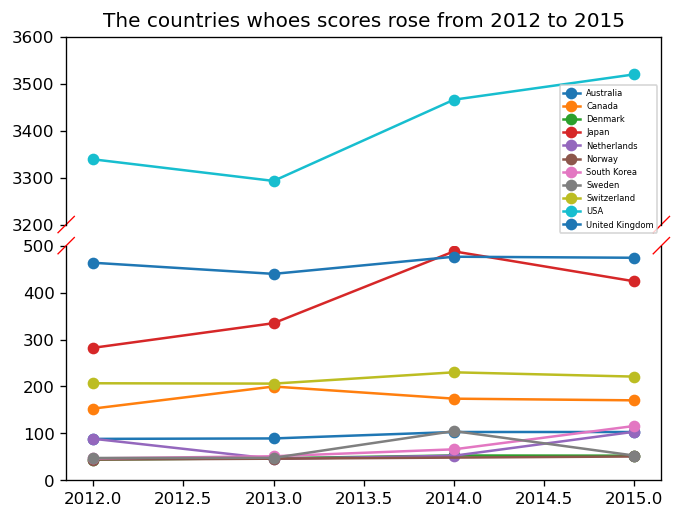

In [14]:
fig = plt.figure(dpi=120)
#the total score of USA is much higher than the other countries so we set a break in the y axis
bax = brokenaxes(
                 ylims=((0, 500), (3200,3600)),
                 hspace=0.1,                
                 despine=False,
                 diag_color='r',              
                
                )
for country in increased_countries.country.unique():
        country_data = df_score.loc[df_score.index.get_level_values('country') == country]
        bax.plot(country_data.index.get_level_values('year'), country_data['score'], marker='o', label=country)
bax.legend(prop = {'size':5},bbox_to_anchor=(1,0.9))
plt.title("The countries whoes scores rose from 2012 to 2015")
plt.show()

As we can see in the graph, USA, Japn, Netherland and South Korea get great progresses

4.What elements make a great university?

In [15]:
#We use the pearson correlation coefficient to see how relavent each element are
df_related=df_filled[['world_rank','quality_of_education','alumni_employment','quality_of_faculty','publications','influence','citations','broad_impact','patents']]
df_corr=df_related.corr()

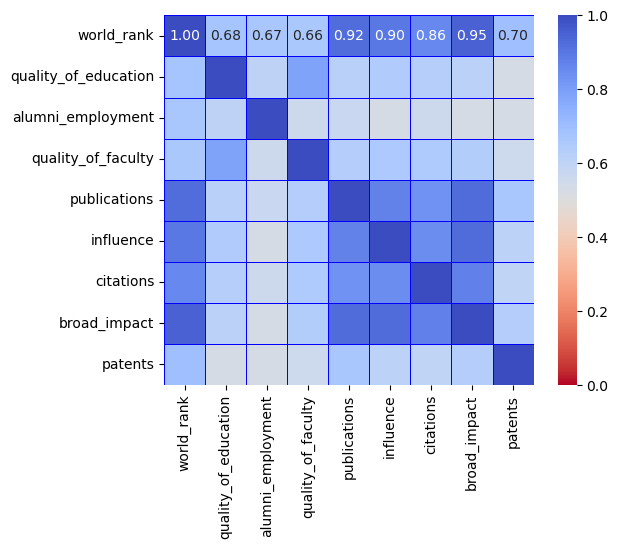

In [16]:
hm1=sns.heatmap(df_corr,
            annot=True, 
            center=0.5,
            fmt='.2f',
            linewidth=0.5,
            linecolor='blue',
            vmin=0, vmax=1,
            xticklabels=True, yticklabels=True,
            square=True,
            cbar=True, 
            cmap='coolwarm_r',
            )

This is the heat map that contains the data of all the institutions in the dataframe

broad_impact            0.949689
publications            0.923037
influence               0.895871
citations               0.856573
patents                 0.698214
quality_of_education    0.676166
alumni_employment       0.668529
quality_of_faculty      0.663864
Name: world_rank, dtype: float64


<Axes: >

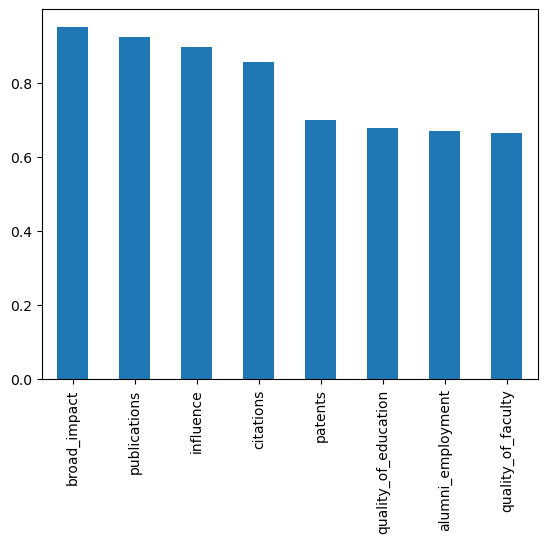

In [17]:
df_world_rank=df_corr['world_rank'].drop('world_rank').sort_values(ascending=False)
print(df_world_rank)
df_world_rank.plot(kind='bar')

We can see that broad impact,publications,influence and citations are highly related to world rank

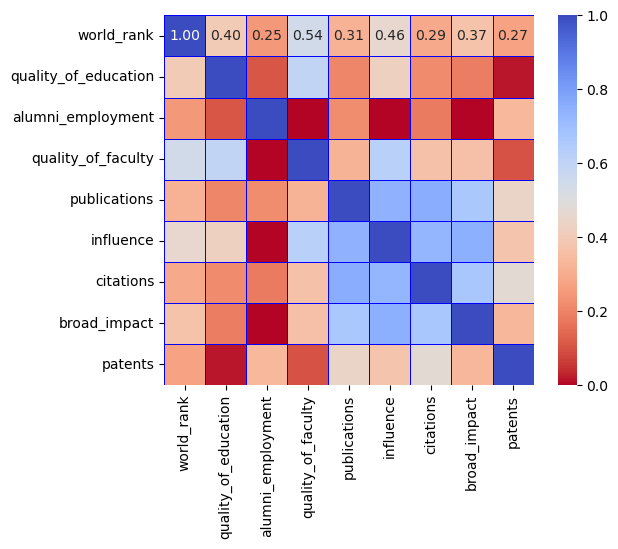

In [18]:
df_related=df_top100[['world_rank','quality_of_education','alumni_employment','quality_of_faculty','publications','influence','citations','broad_impact','patents']]
df_corr=df_related.corr()
hm2=sns.heatmap(df_corr,
            annot=True, 
            center=0.5,
            fmt='.2f',
            linewidth=0.5, 
            linecolor='blue',
            vmin=0, vmax=1,
            xticklabels=True, yticklabels=True,
            square=True,
            cbar=True,
            cmap='coolwarm_r',
            )

This is the heat map that only contains the data of top 100 institutions

<Axes: >

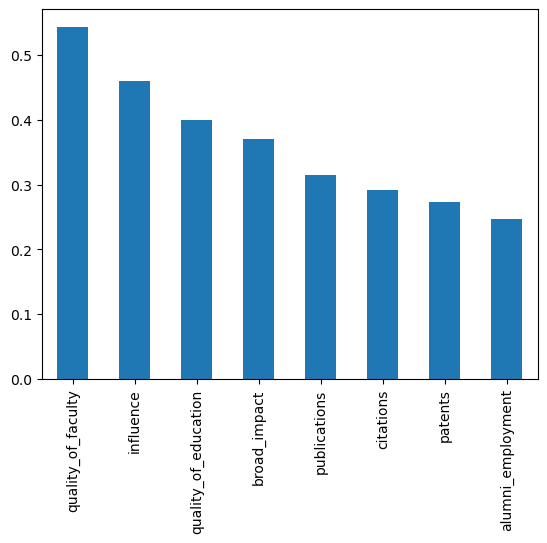

In [19]:
df_world_rank=df_corr['world_rank'].drop('world_rank').sort_values(ascending=False)
df_world_rank.plot(kind='bar')

As we can find that the quality of faculty becomes the most related element to world rank

5.other founds:
    (1)We can find a 4X4 square in both graphs that contains broad impact,publications,influence and citations that has a deeper color,which means these four elements are highly related to each other
    (2)We can find that alumni employment is not highly related to world rank, and even not related to influence and broad impact, which means a good university may not inevitably lead to good employments